Let's build an MNIST image recognition model using the saved functions. Goal is to get used to the callback system built in class

In [63]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import torch.nn.functional as F
import matplotlib.pyplot as plt
from functools import partial
import math
import matplotlib.pyplot as plt

from exp.nb import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [13]:
x_train,y_train,x_valid,y_valid = get_data()

In [14]:
x_train,x_valid = normalize_to(x_train,x_valid)

In [33]:
# flatten
x_train,x_valid = x_train.view(x_train.shape[0],-1),x_valid.view(x_valid.shape[0],-1)
x_train.shape,x_valid.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

In [34]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [35]:
x_train.mean(),x_train.std()

(tensor(1.3577e-08), tensor(1.))

In [36]:
print('Shape of training data: ', x_train.shape, y_train.shape),
print('Shape of validation data: ', x_valid.shape, y_valid.shape)
print('Type of training data:', x_train.dtype, y_train.dtype)
print('Type of validation data:', x_valid.dtype, y_valid.dtype)

Shape of training data:  torch.Size([60000, 784]) torch.Size([60000])
Shape of validation data:  torch.Size([10000, 784]) torch.Size([10000])
Type of training data: torch.float32 torch.int64
Type of validation data: torch.float32 torch.int64


In [37]:
nh, bs = 50, 512
loss_func = F.cross_entropy
data = DataBunch(*get_dls(train_ds, valid_ds, bs), 10)


## Visualizing data

In [46]:
images, labels = next(iter(trainloader))

In [48]:
images[0].dtype, labels[0].dtype

(torch.float32, torch.int64)

In [55]:
images[0].max()

tensor(1.)

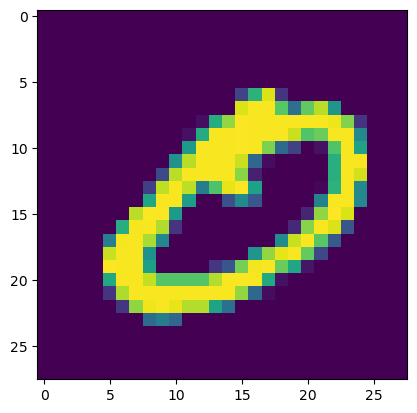

In [14]:
plt.imshow(images[2].view(28, 28))

In [16]:
labels[2]

tensor(0)

## Basic model

using a simple architecture with 2 fully connected layers

In [42]:
learn= Learner(*get_model(data), loss_func=F.cross_entropy, data=data)

In [38]:
def fit(epochs, learn):
    for epoch in range(epochs):
        learn.model.train()
        for xb,yb in learn.data.train_dl:
            loss = learn.loss_func(learn.model(xb), yb)
            loss.backward()
            learn.opt.step()
            learn.opt.zero_grad()

        learn.model.eval()
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in learn.data.valid_dl:
                pred = learn.model(xb)
                tot_loss += learn.loss_func(pred, yb)
                tot_acc  += accuracy(pred,yb)
        nv = len(learn.data.valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [45]:
xb, yb = next(iter(learn.data.train_dl))
pred = learn.model(xb)
pred.shape

torch.Size([512, 10])

In [43]:
learn.model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [46]:
loss,acc = fit(1, learn)

0 tensor(0.2546) tensor(0.9201)


## Callbacks

### V1

In [48]:
def one_batch(xb, yb, cbh):
    """given a batch and callback handler"""
    if not cbh.begin_batch(xb, yb): return
    loss = cbh.learn.loss_func(cbh.learn.model(xb), yb)
    if not cbh.after_loss(loss): return
    loss.backward()
    if cbh.after_backward(): cbh.learn.opt.step()
    if cbh.after_step(): cbh.learn.opt.zero_grad()

def all_batches(dl, cbh):
    print('all_batches, cbh.learn.stop is ', cbh.learn.stop)
    for xb,yb in dl:
        one_batch(xb, yb, cbh)
        if cbh.do_stop():
            print('cbh.learn.stop is', cbh.learn.stop) 
            return

def fit(epochs, learn, cbh):
    if not cbh.begin_fit(learn): return
    for epoch in range(epochs):
        if not cbh.begin_epoch(epoch): continue
        print('fitting')
        all_batches(learn.data.train_dl, cbh)

        if cbh.begin_validate():
            with torch.no_grad():
                print('validating, cbh.learn.stop is ', cbh.learn.stop)
                all_batches(learn.data.valid_dl, cbh)
        if cbh.do_stop() or not cbh.after_epoch(): break
    cbh.after_fit()


In [49]:
class Callback():
    def begin_fit(self, learn):
        self.learn = learn
        return True
    def after_fit(self): return True
    def begin_epoch(self, epoch):
        self.epoch=epoch
        return True
    def begin_validate(self): return True
    def after_epoch(self): return True
    def begin_batch(self, xb, yb):
        self.xb, self.yb = xb, yb
        return True
    def after_loss(self, loss):
        self.loss = loss
        return True
    def after_backward(self): return True
    def after_step(self): return True

In [53]:
class CallbackHandler():
    def __init__(self, cbs=None):
        self.cbs = cbs if cbs else []

    def begin_fit(self, learn):
        self.learn, self.in_train = learn, True
        learn.stop = False
        res = True
        for cb in self.cbs: res = res and cb.begin_fit(learn)
        return res # if any of the callbacks return False, stop
    
    def after_fit(self):
        res = not self.in_train # if we didn't do training, don't do validation
        for cb in self.cbs: res = res and cb.after_fit()
        return res

    def begin_epoch(self, epoch):
        self.learn.model.train()
        self.in_train = True
        res = True
        for cb in self.cbs: res = res and cb.begin_epoch(epoch)
        return res

    def begin_validate(self):
        self.learn.model.eval()
        self.in_train=False
        res = True
        for cb in self.cbs: res = res and cb.begin_validate()
        return res

    def after_epoch(self):
        res = True
        for cb in self.cbs: res = res and cb.after_epoch()
        return res
    
    def begin_batch(self, xb, yb):
        res = True
        for cb in self.cbs: res = res and cb.begin_batch(xb, yb)
        return res

    def after_loss(self, loss):
        res = self.in_train
        for cb in self.cbs: res = res and cb.after_loss(loss)
        return res

    def after_backward(self):
        res = True
        for cb in self.cbs: res = res and cb.after_backward()
        return res

    def after_step(self):
        res = True
        for cb in self.cbs: res = res and cb.after_step()
        return res
    
    def do_stop(self):
        try:    
            return self.learn.stop # stop if there is signal to stop from self.learn
        finally: pass#self.learn.stop = False # the stop signal does not persist to the next all_batches
        

In [54]:
class Testcallback(Callback):
    def begin_fit(self, learn):
        super().begin_fit(learn)
        self.n_iters = 0
        return True

    def begin_batch(self, xb, yb):
        super().begin_batch(xb, yb)
        return True 

    def after_step(self):
        self.n_iters += 1
        #print(self.n_iters)
        if self.n_iters > 10: 
            self.learn.id = 3
            self.learn.stop = True
        return True 

In [55]:
fit(1, learn, cbh=CallbackHandler([Testcallback()]))

fitting
all_batches, cbh.learn.stop is  False
cbh.learn.stop is True
validating, cbh.learn.stop is  True
all_batches, cbh.learn.stop is  True
cbh.learn.stop is True


this code is very hard to debug, there are 3 classes modifying each other and store the other as attribute

also the callback trigger was called from inside training loop, making it even more complicated

### Improved callbacks

we combine the training loop function with the callback handler into the same object called Runner. Runner accepts a list of callbacks when initializing

callback is its own object, it gets passed the runner object when needed

In [64]:
learn = Learner(*get_model(data), loss_func, data)

In [65]:
stats = AvgStatsCallback(['accuracy'], [accuracy])
run = Runner(cbs=stats)

In [66]:
run.fit(2, learn)

Epoch:  0
train: loss 0.00, accuracy 0.82
valid: loss 0.00, accuracy 0.90
Epoch:  1
train: loss 0.00, accuracy 0.94
valid: loss 0.00, accuracy 0.93


- We improved the AvgStatsCallback from Jeremy's version by printing also the name of the metrics being avg and printed
- AngStatsCallback shows the running average of all the metrics it was asked to keep track of, including loss by default

## Anneal

In [7]:
def annealer(f):
    "A function factory that take a function f use that for annealing"
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

In [8]:
f = sched_lin(1,2) # a function that takes pos between 0 and 1 and anneal it between 1 and 2
f(0.3)

1.3

In [10]:
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start)**pos

def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]




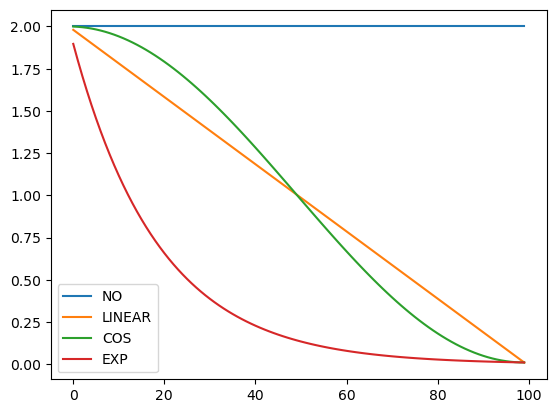

In [11]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01, 1, 100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In [19]:
def combine_scheds(pcts, scheds):
    assert sum(pcts)==1.
    pcts = torch.tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        if idx == len(scheds): idx -= 1
        actual_pos = (pos - pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [59]:
onecycle_sched = combine_scheds([0.3, 0.7], [sched_cos(0.1, 0.2), sched_cos(0.2, 0.01)])

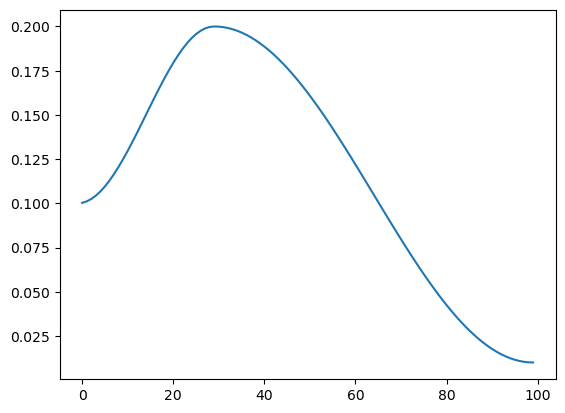

In [60]:
plt.plot(a, [onecycle_sched(o) for o in p])

In [61]:
cbfs = [Recorder,
        partial(AvgStatsCallback, 'accuracy', accuracy),
        partial(ParamScheduler, 'lr', onecycle_sched)]

In [62]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [63]:
run.fit(3, learn)

train: loss 2.24, accuracy 0.88
valid: loss 2.12, accuracy 0.90
train: loss 2.12, accuracy 0.90
valid: loss 2.11, accuracy 0.90
train: loss 2.12, accuracy 0.90
valid: loss 2.11, accuracy 0.90


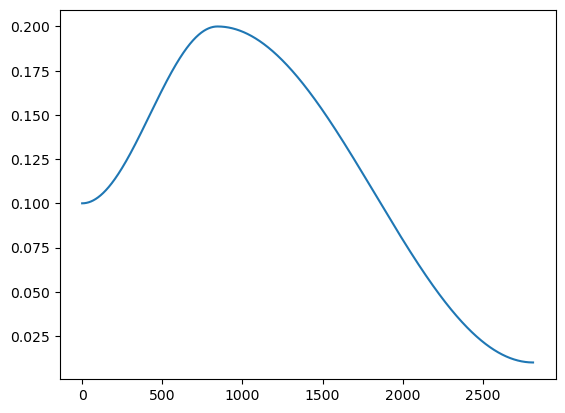

In [64]:
run.recorder.plot_lr()

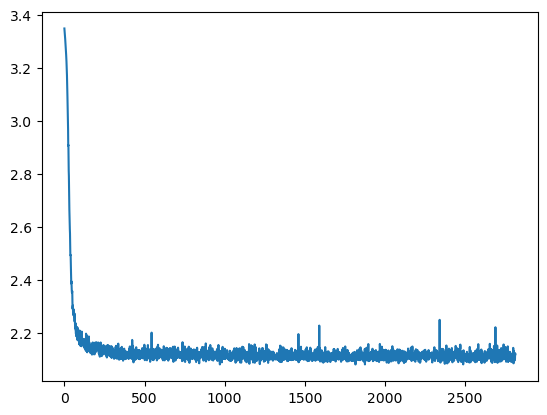

In [58]:
run.recorder.plot_loss()

## CUDA CNN Hooks

In [67]:
# get back image in square form since our data was loaded as a flat vector
def mnist_resize(x): return x.view(-1, 1, 28, 28) 

In [83]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d(1, 8, 5, padding=2, stride=2), # 28 + 4 - 4 - 1 / 2 + 1 = 14
        nn.Conv2d(8, 16, 3, padding=1, stride=2), # 14 + 2 - 2 -1 / 2 + 1 = 7
        nn.Conv2d(16, 32, 3, padding=1, stride=2), # 7 + 2 - 2 - 1 / 2 + 1 = 4
        nn.Conv2d(32, 32, 3, padding=1, stride=2), # 4 + 2 - 2 - 1 / 2 + 1 = 2
        # nn.AdaptiveAvgPool2d(1), # remove since it feels like we are loosing information
        Lambda(flatten),
        nn.Linear(128, data.c)
    )

In [84]:
model = get_cnn_model(data)

#### Tip!
It's a good idea to print out the model , one data point, and try fitting on one element of data, and a tiny set

In [85]:
model

Sequential(
  (0): Lambda()
  (1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Lambda()
  (6): Linear(in_features=128, out_features=10, bias=True)
)

In [86]:
xb, yb = next(iter(data.train_dl))
xb.shape, yb.shape

(torch.Size([512, 784]), torch.Size([512]))

In [87]:
y_pred = model(xb) 
y_pred.shape

torch.Size([512, 10])

In [88]:
y_pred[0]

tensor([-0.0974, -0.0362, -0.0502,  0.0331, -0.0186,  0.0237, -0.0715,  0.0003,
         0.0184,  0.1321], grad_fn=<SelectBackward0>)

In [89]:
loss_func(y_pred, yb)

tensor(2.3063, grad_fn=<NllLossBackward0>)

In [90]:
cbfs = [Recorder, partial(AvgStatsCallback, 'accuracy', accuracy)]

In [93]:
opt = optim.SGD(model.parameters(), lr=0.1)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [94]:
%time run.fit(1, learn)

Epoch:  0
train: loss 0.00, accuracy 0.76
valid: loss 0.00, accuracy 0.89
CPU times: user 16.4 s, sys: 44.9 s, total: 1min 1s
Wall time: 21.7 s


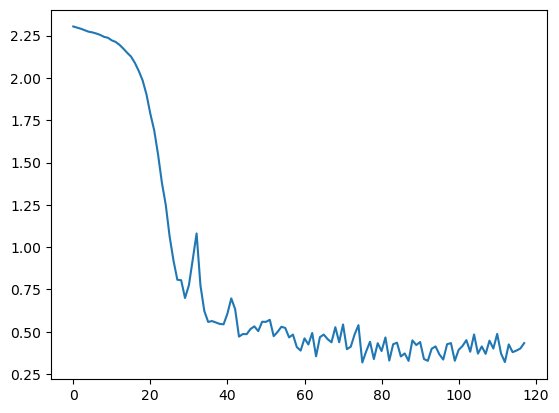

In [96]:
run.cbs[1].plot_loss()

ok this kinda works now, we'll use CUDA hooks next